In [80]:
%reset -f

from functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

from PIL import  Image
from sklearn.preprocessing import LabelEncoder
from matplotlib.image import imread
from random import randrange

import cv2 # SIFT

from sklearn import cluster, metrics

path_images = "./dataset/images/"

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [81]:
# Starting time
t0 = time()

In [82]:
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


In [83]:
dataset = pd.read_csv("./dataset/data.csv")
dataset.head()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category_1,category_2,category_3
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets


# PART 1 : SIFT

Description du webinaire (compétences abordées) : L’objectif est d’acquérir
la compétence de prétraitement d’images via SIFT ou ORB, afin de créer des
“features” pour chacune des images sous forme de “bag of visual words”, puis
d’analyser ces features d’images, en particulier la capacité à séparer
naturellement les images selon les catégories réelles via une réduction de
dimension T-SNE et un affichage en 2D.


## Création des labels des photos à partir du nom des images

In [84]:
print("TEST")
#img = Image.open(path_images + "0906fd9cc604fbba05a502e01d763cd9.jpg")

# Afficher l'image chargée
#img.show()

TEST


In [85]:
data = dataset[["image", "category_1"]].rename(columns={"image": "image_path", "category_1": "label_name"})
data

,image_path,label_name
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care


In [86]:
list_labels = data["label_name"].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

##### Label Encoding

In [87]:
#data["image_path"] = list_photos
label_encoder = LabelEncoder()

data["label"] = label_encoder.fit_transform(data["label_name"])
data

,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [88]:
display(data.groupby("label").count())
print("The data is balanced !")

,image_path,label_name
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


The data is balanced !


## Affichage d'exemples d'images par label

Home Furnishing
-------
For this category, we have 150 images.


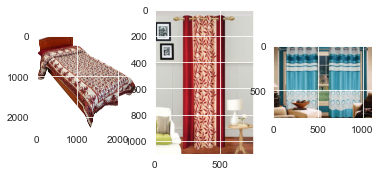

Baby Care
-------
For this category, we have 150 images.


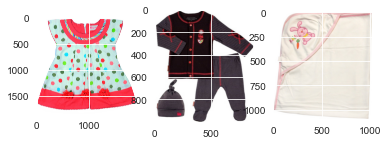

Watches
-------
For this category, we have 150 images.


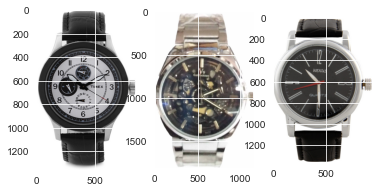

Home Decor & Festive Needs
-------
For this category, we have 150 images.


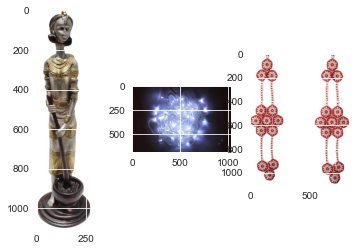

Kitchen & Dining
-------
For this category, we have 150 images.


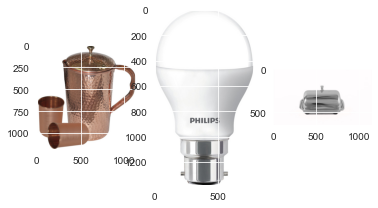

Beauty and Personal Care
-------
For this category, we have 150 images.


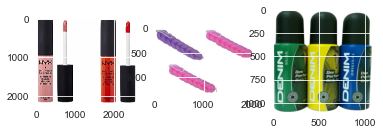

Computers
-------
For this category, we have 150 images.


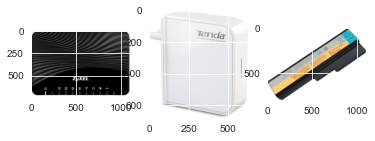

In [89]:
n_categories = len(list_labels)
n_photos = len(list_photos)

def list_fct(category, list_img_in_dir, df, img_column_name, label_column_name) :
    """

    :param category:
    :param list_img_in_dir:
    :param df:
    :param img_column_name:
    :param label_column_name:
    :return:

    :UC: photos in the local directory must match the photos in the dataset df
    """
    list_images_for_a_category = []
    for photo in list_img_in_dir: # 1050 photos in our local directory
        # we get the row in our dataset that matches the photo in the local directory
        img_row = df[df[img_column_name] == photo]
        if (img_row[label_column_name] == category).values[0]: # to np array and get the first element
            list_images_for_a_category.append(photo)
    return list_images_for_a_category



def display_images_per_category(categories, df, path, img_column_name, label_column_name, n_photos_to_display=3):
    """

    :param categories:
    :param df:
    :param path:
    :param img_column_name:
    :param label_column_name:
    :param n_photos_to_display: (from 2 to 9)
    :return:
    """
    for category in categories :
        print(category)
        print("-------")
        # we get the list of photos for one category
        list_photos_cat =  list_fct(category, list_photos, df, img_column_name, label_column_name)
        n = len(list_photos_cat)
        print("For this category, we have", n, "images.")

        for i in range(n_photos_to_display):
            plt.subplot(int('1{}0'.format(n_photos_to_display)) + 1 + i)

            j = randrange(0, n) # from 0 to n-1
            filename = path + list_photos_cat[j] # we choose randomly a photo
            img = imread(filename)
            plt.imshow(img)

        plt.show()

display_images_per_category(list_labels, data, path_images, "image_path", "label_name")

## Détermination et affichage des descripteurs SIFT

* L'image contient 319 descripteurs
* Chaque descripteur est un vecteur de longueur 128

In [90]:
filename = path_images + list_photos[0]
img = Image.open(filename)

# Afficher l'image chargée
img.show()

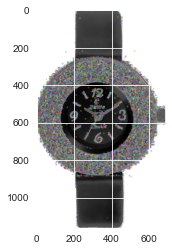

Descripteurs :  (4150, 128)

[[  3.  52. 133. ...   4.  30.  22.]
 [ 11.   1.   4. ...   0.   0.   0.]
 [  0.   0.   1. ...  14.   2.   4.]
 ...
 [ 14.   3.   5. ...   0.   0.   0.]
 [ 34.  18.   9. ...   0.   2.   3.]
 [  9. 128.  45. ...   0.   0.   0.]]


In [91]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path_images + list_photos[0],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

# identification of key points and associated descriptors

sift_keypoints = []
temps1=time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num % 100 == 0 : print(image_num)
    image = cv2.imread(path_images + list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

np.savez_compressed('dataset/keypoints_by_img.npz', sift_keypoints_by_img)
np.savez_compressed('dataset/keypoints_all.npz', sift_keypoints_all)

In [92]:
# load numpy array from npz file
# load dict of arrays
#dict_data = np.load('dataset/descripteurs.npz')
# extract the first array

dict_data = np.load('dataset/keypoints_all.npz')
sift_keypoints_all = dict_data['arr_0']
# print the array
#print(data)

In [93]:
dict_data = np.load('dataset/keypoints_by_img.npz', allow_pickle=True)
sift_keypoints_by_img = dict_data['arr_0']

In [94]:
x = np.load('dataset/keypoints_by_img.npz', mmap_mode='r')
for k in x.files:
    print(k)

arr_0


In [95]:
sift_keypoints_by_img

array([array([[ 8.,  8., 10., ...,  4.,  1.,  3.],
              [ 0., 10., 49., ...,  0.,  0.,  1.],
              [10., 11.,  5., ...,  1.,  0.,  0.],
              ...,
              [28.,  0.,  0., ...,  0.,  0.,  1.],
              [ 0.,  0.,  0., ...,  5.,  0.,  0.],
              [27.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32),
       array([[ 0.,  1.,  2., ...,  9., 21.,  5.],
              [96., 20.,  0., ...,  9.,  2.,  0.],
              [55., 16.,  0., ...,  0.,  1.,  0.],
              ...,
              [88.,  9.,  0., ...,  0.,  4., 16.],
              [ 3.,  1.,  0., ...,  0.,  0.,  0.],
              [13.,  0.,  0., ...,  0.,  0.,  2.]], dtype=float32),
       array([[ 1.,  2.,  6., ...,  0.,  2., 70.],
              [ 3.,  4.,  5., ...,  1.,  8., 14.],
              [58.,  9.,  5., ..., 20., 34., 14.],
              ...,
              [ 8., 17., 30., ...,  7., 12.,  9.],
              [62., 74., 10., ..., 26., 38., 25.],
              [27., 20., 34., ..., 43.,  8

## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [96]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :            11.91 secondes


## Création des features des images
* Pour chaque image :
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [97]:
# Creation of histograms (features)
temps1=time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             2.88 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [98]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 498)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [99]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)


C:\Users\oumei\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

In [100]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()


ValueError: The palette list has the wrong number of colors.

<Figure size 576x360 with 0 Axes>

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=4, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [ ]:
df_tsne.groupby("cluster").count()["class"]

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

In [ ]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [3, 1, 2, 0]
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']


cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

In [ ]:
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[i for i in "0123"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# PART 2 : CNN and Transfert Learning

## 1) CNN

In [ ]:
filename = path_images + "893aa5ed55f7cff2eccea7758d7a86bd.jpg"

In [ ]:
from keras.applications.vgg16 import VGG16

model = VGG16() # Création du modèle VGG-16 implementé par Keras

In [ ]:
from keras_preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img(filename, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [ ]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [ ]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

## 2) Transfert Learning

#### 1) Stratégie : fine-tuning total

In [ ]:
for layer in model.layers:
    layer.trainable = True

#### 2) Stratégie : extraction des features

In [ ]:
for layer in model.layers:
    layer.trainable = False

#### 3) Stratégie : fine-tuning partiel

In [ ]:
# Ne pas entraîner les 5 premières couches (les plus basses)
for layer in model.layers[:5]:
    layer.trainable = False

#### Conclusion TL : compile puis fit !

In [ ]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)


In [ ]:
# End of notebook time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))